In [1]:
# Import libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics 
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

In [2]:
# Read in main dataset

df = pd.read_csv('application_train.csv')
df.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
df.shape

(307511, 122)

In [4]:
# Here are the variables I selected in Assignment 1. 

mod_1_vars = df[['EXT_SOURCE_3',
                'EXT_SOURCE_2',
                'EXT_SOURCE_1',
                'DAYS_BIRTH',
                'REGION_RATING_CLIENT_W_CITY', 
                'REGION_RATING_CLIENT', 
                'DAYS_LAST_PHONE_CHANGE', 
                'DAYS_ID_PUBLISH',
                'REG_CITY_NOT_WORK_CITY',
                'FLAG_EMP_PHONE']]
mod_1_vars.head(5)

,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1,DAYS_BIRTH,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,REG_CITY_NOT_WORK_CITY,FLAG_EMP_PHONE
0,0.139376,0.262949,0.083037,-9461,2,2,-1134.0,-2120,0,1
1,NaN,0.622246,0.311267,-16765,1,1,-828.0,-291,0,1
2,0.729567,0.555912,NaN,-19046,2,2,-815.0,-2531,0,1
3,NaN,0.650442,NaN,-19005,2,2,-617.0,-2437,0,1
4,NaN,0.322738,NaN,-19932,2,2,-1106.0,-3458,1,1


If we look at the 10 variables I selected in Assignment 1, we can see there are a substantial amount of 'NaN' values. This is problematic because many ML algorithms cannot deal with 'NaN' values. There are a couple ways to deal with this, and the easiest (for me) is to simply drop the rows with 'NaN' values. However, we must perform a few other functions in order to ensure that we don't remove too many rows. If we simply used the df.dropna() function on the current dataset, we would be left with only 8000 rows, or about 3% of our original dataset.

There are 122 variables, most of which will not be used in this project. Many of these variable have a majority of their values as 'NaN', so it makes sense to remove these columns all together. The following code will remove variable that have more than 25% of their value as 'NaN':

In [5]:
# Delete columns that have more than 25% NaN values

perc = 25.0

df = df.dropna(thresh = int(((100 - perc)/100)*df.shape[0] + 1), 
               axis   = 1)
df.shape

(307511, 72)

Next, we will remove all rows that have 'NaN' and hopefully we will be left with a large chunk of our dataset:

In [6]:
df = df.dropna()
df.shape

(244280, 72)

We can see that we removed 63,231 rows that contained at least 1 'NaN' value. We are left with 244,280 rows containing 72 variables. For this assignment, I am okay with this size of a dataset. In the real world, we would likely use imputation on some of the variables in order to have a larger dataset.

Next, lets take a look at the data types:

In [7]:
df.dtypes.value_counts()

int64      41
float64    20
object     11
dtype: int64

float64 and int64 are numeric and are fine as is. Object type variable will need to be encoded. Lets take a look atk the number of unique classes in each object variable:

In [8]:
df.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               7
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             5
NAME_HOUSING_TYPE              6
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
dtype: int64

In order to simplify the splits in our tree, we will remove 'ORGANIZATION_TYPE' because it has a very high number of unique values:

In [9]:
df = df.drop(columns = ['ORGANIZATION_TYPE'])
df.shape

(244280, 71)

We are left with the following columns:

In [10]:
df.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CI

Now that we have a cleaned dataset (which should have been done in Assignment 1, but I did not do so) lets check that the variables I originally selected in Assignment 1 are actually in our new, cleaned dataset:

In [11]:
for i in mod_1_vars:
    if i in df.columns:
        print('variable in dataset: ', i)
    else:
        print('**variable NOT IN dataset: ', i)
        
df_clean = df

variable in dataset:  EXT_SOURCE_3
variable in dataset:  EXT_SOURCE_2
**variable NOT IN dataset:  EXT_SOURCE_1
variable in dataset:  DAYS_BIRTH
variable in dataset:  REGION_RATING_CLIENT_W_CITY
variable in dataset:  REGION_RATING_CLIENT
variable in dataset:  DAYS_LAST_PHONE_CHANGE
variable in dataset:  DAYS_ID_PUBLISH
variable in dataset:  REG_CITY_NOT_WORK_CITY
variable in dataset:  FLAG_EMP_PHONE


Unfortunately it looks like the variable 'EXT_SOURCE_1' is not in our new dataset. This is because it contained more than 25% value as 'NaN'. Based on how I originally selected these variables in Assignment 1, I will select the replacement variable simply based on correlation. This new variable is: 'REG_CITY_NOT_LIVE_CITY'

Here is the list of updated variables for assignment 1:

In [12]:
mod_1_vars = df[['EXT_SOURCE_3',
                'EXT_SOURCE_2',
                'DAYS_BIRTH',
                'REGION_RATING_CLIENT_W_CITY', 
                'REGION_RATING_CLIENT', 
                'DAYS_LAST_PHONE_CHANGE', 
                'DAYS_ID_PUBLISH',
                'REG_CITY_NOT_WORK_CITY',
                'FLAG_EMP_PHONE',
                'REG_CITY_NOT_LIVE_CITY']]
mod_1_vars.head(5)

,EXT_SOURCE_3,EXT_SOURCE_2,DAYS_BIRTH,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,REG_CITY_NOT_WORK_CITY,FLAG_EMP_PHONE,REG_CITY_NOT_LIVE_CITY
0,0.139376,0.262949,-9461,2,2,-1134.0,-2120,0,1,0
2,0.729567,0.555912,-19046,2,2,-815.0,-2531,0,1,0
5,0.621226,0.354225,-16941,2,2,-2536.0,-477,0,1,0
6,0.492060,0.724000,-13778,2,2,-1562.0,-619,0,1,0
7,0.540654,0.714279,-18850,3,3,-1070.0,-2379,1,1,0


**CLASSIFICATION TREE**

Now we can begin creating our models. Since we are creating a classification tree, we need to deal with the continuous variabls in our dataset. For simplicity we will split these into 2 groups, either greater than the median or less than the median. df_clean.dtypes.value_counts()Then, we will split the data into train and test sets, and then build a classification tree. 

In [13]:
df['EXT_3'] = df['EXT_SOURCE_3']>df['EXT_SOURCE_3'].median()
df['EXT_2'] = df['EXT_SOURCE_2']>df['EXT_SOURCE_2'].median()
df['DAYS_B'] = df['DAYS_BIRTH']>df['DAYS_BIRTH'].median()
df['DAYS_LPC'] = df['DAYS_LAST_PHONE_CHANGE']>df['DAYS_LAST_PHONE_CHANGE'].median()
df['DAYS_IDP'] = df['DAYS_ID_PUBLISH']>df['DAYS_ID_PUBLISH'].median()
df.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,EXT_3,EXT_2,DAYS_B,DAYS_LPC,DAYS_IDP
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,1.0,False,False,True,False,True
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,True,False,False,False,True
5,100008,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,...,0.0,0.0,0.0,1.0,1.0,True,False,False,False,True
6,100009,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,...,0.0,0.0,1.0,1.0,2.0,False,True,True,False,True
7,100010,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,...,0.0,0.0,0.0,0.0,0.0,True,True,False,False,True


In [14]:
# Create a new DF that we will use for our model and split into train and test sets.
# for simplicity we won't include a validation set.

feature_cols = ['EXT_3',
                'EXT_2',
                'DAYS_B',
                'REGION_RATING_CLIENT_W_CITY', 
                'REGION_RATING_CLIENT', 
                'DAYS_LPC', 
                'DAYS_IDP',
                'REG_CITY_NOT_WORK_CITY',
                'FLAG_EMP_PHONE',
                'REG_CITY_NOT_LIVE_CITY']
X = df[feature_cols]
y = df.TARGET

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [15]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((195424, 10), (48856, 10), (195424,), (48856,))

In [16]:
class_model = DecisionTreeClassifier(criterion = 'entropy',
                             max_depth = 3)

class_model = DecisionTreeClassifier()

class_model = class_model.fit(X_train, y_train)

y_pred = class_model.predict(X_test)

In [17]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.920603405927624


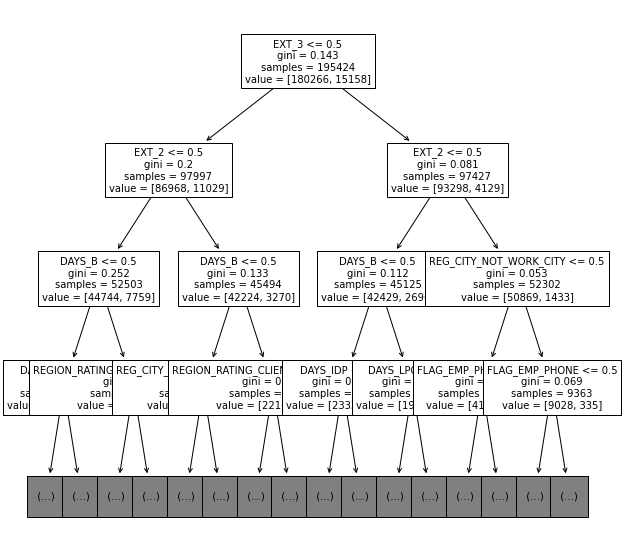

In [18]:
plt.figure(figsize=(10,10))

plot_tree(class_model, 
          max_depth = 3, 
          fontsize = 10,
          feature_names = feature_cols)
plt.show()

**RANDOM FOREST**

Using the 10 variables selected in Assignment 1 and a max_depth of 3, we achieved an accuracy of 0.92, which is pretty good. Now we will build a random forest to see if we can improve the accuracy, and we will also see if there are other more important variables that could be used.

First, we need to encode our 'object' type variables using the sklearn LabelEncoder():

In [33]:
le = LabelEncoder()
count = 0

for col in df:
    if df[col].dtype == 'object':
        if len(list(df[col].unique())) <= 2:
            le.fit(df[col])
            df[col] = le.transform(df[col])
            
            count += 1
            
df = pd.get_dummies(df)

print('%d columns were encoded.' % count), print(df.shape)

0 columns were encoded.
(244280, 109)


(None, None)

In [34]:
X = df[df.columns.difference(['TARGET',
                              'EXT_3',
                              'EXT_2',
                              'DAYS_B',
                              'DAYS_LPC',
                              'DAYS_IDP'])]
y = df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [35]:
X_train.shape, y_train.shape

((195424, 103), (195424,))

In [36]:
model = RandomForestClassifier(n_estimators = 100, 
                               max_depth=5, 
                               max_features=0.5,
                               min_samples_leaf=4)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features=0.5, min_samples_leaf=4)

In [37]:
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.9207057475028656


In [38]:
features = X_train.columns
feat_importance = pd.DataFrame(model.feature_importances_, columns = ['SCORE'])
feat_importance['FEATURE'] = features
feat_importance = feat_importance.sort_values('SCORE', ascending=False)
print(feat_importance.head(10))

       SCORE                                            FEATURE
23  0.525895                                       EXT_SOURCE_3
22  0.333771                                       EXT_SOURCE_2
15  0.035011                                         DAYS_BIRTH
57  0.016764               NAME_EDUCATION_TYPE_Higher education
13  0.013419                                      CODE_GENDER_M
60  0.011300  NAME_EDUCATION_TYPE_Secondary / secondary special
12  0.010901                                      CODE_GENDER_F
16  0.010579                                      DAYS_EMPLOYED
2   0.004902                                    AMT_GOODS_PRICE
18  0.004719                             DAYS_LAST_PHONE_CHANGE


From the feature importance chart we can see that the top 10 variable are NOT the same as the ones that I selected in Assignment 1. EXT_SOURCE_3, EXT_SOURCE_2, DAYS_BIRTH, and DAYS_LAST_PHONE_CHANGE are the only variables that are in the top 10 most important according to our random forest:

In [24]:
rf_vars = list(feat_importance[:10]['FEATURE'])
mod1_var = list(mod_1_vars.columns)

for i in mod1_var:
    if i in rf_vars:
        print('top 10 variable: ', i)
    else:
        print('NOT A TOP 10 VARIABLE: ', i)

top 10 variable:  EXT_SOURCE_3
top 10 variable:  EXT_SOURCE_2
top 10 variable:  DAYS_BIRTH
NOT A TOP 10 VARIABLE:  REGION_RATING_CLIENT_W_CITY
NOT A TOP 10 VARIABLE:  REGION_RATING_CLIENT
NOT A TOP 10 VARIABLE:  DAYS_LAST_PHONE_CHANGE
NOT A TOP 10 VARIABLE:  DAYS_ID_PUBLISH
NOT A TOP 10 VARIABLE:  REG_CITY_NOT_WORK_CITY
NOT A TOP 10 VARIABLE:  FLAG_EMP_PHONE
NOT A TOP 10 VARIABLE:  REG_CITY_NOT_LIVE_CITY


**NEW RANDOM FOREST AND CLASSIFICATION TREE**

Now we will create a new classification tree and random forest based on the 10 most important variables from our random forest and see how the accuracy compares to our first classification tree:

In [25]:
# Print our new top 10 variables:

rf_vars

['EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'DAYS_BIRTH',
 'CODE_GENDER_M',
 'NAME_EDUCATION_TYPE_Higher education',
 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'CODE_GENDER_F',
 'DAYS_EMPLOYED',
 'NAME_INCOME_TYPE_Working',
 'AMT_GOODS_PRICE']

In [26]:
# RANDOM FOREST WITH NEW VARIABLES

X = df[['EXT_SOURCE_3',
        'EXT_SOURCE_2',
        'DAYS_BIRTH',
        'CODE_GENDER_M',
        'NAME_EDUCATION_TYPE_Higher education',
        'NAME_EDUCATION_TYPE_Secondary / secondary special',
        'CODE_GENDER_F',
        'DAYS_EMPLOYED',
        'AMT_GOODS_PRICE',
        'DAYS_LAST_PHONE_CHANGE']]

y = df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
X_train.shape, y_train.shape

((195424, 10), (195424,))

In [27]:
model = RandomForestClassifier(n_estimators = 100, 
                               max_depth=5, 
                               max_features=0.5,
                               min_samples_leaf=4)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features=0.5, min_samples_leaf=4)

In [28]:
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.9207057475028656


Our accuracy still hovers around 0.92, similar to our original classification tree. Now we will rebuild the classification tree using our new variables and display the tree:

In [29]:
# NEW CLASSIFICATION TREE

X = df[['EXT_SOURCE_3',
        'EXT_SOURCE_2',
        'DAYS_BIRTH',
        'CODE_GENDER_M',
        'NAME_EDUCATION_TYPE_Higher education',
        'NAME_EDUCATION_TYPE_Secondary / secondary special',
        'CODE_GENDER_F',
        'DAYS_EMPLOYED',
        'AMT_GOODS_PRICE',
        'DAYS_LAST_PHONE_CHANGE']]

y = df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
X_train.shape, y_train.shape

((195424, 10), (195424,))

In [30]:
class_model = DecisionTreeClassifier(criterion = 'entropy',
                                     max_depth = 5)

class_model = DecisionTreeClassifier()

class_model = class_model.fit(X_train, y_train)

y_pred = class_model.predict(X_test)

In [31]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.85676273129196


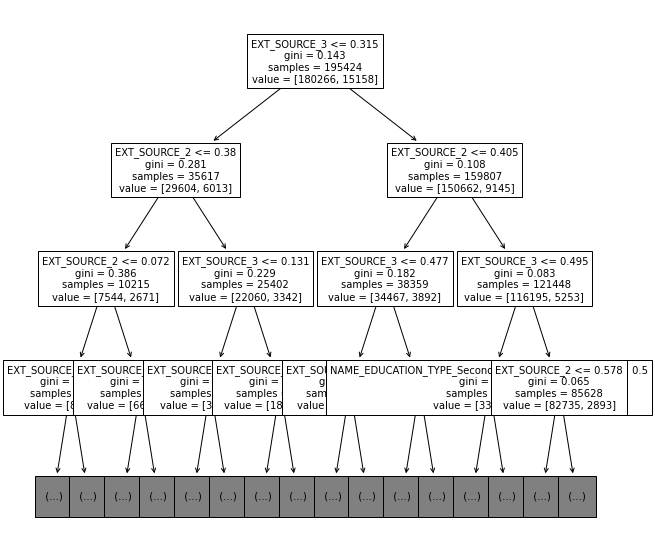

In [32]:
plt.figure(figsize=(10,10))

plot_tree(class_model, 
          max_depth = 3, 
          fontsize = 10,
          feature_names = X.columns)
plt.show()

Interestingly after we used a random forest to find the top 10 variables based on feature importance, our accuracy dropped from 0.92 to 0.86. There are a few reasons that this could have happened. For one, there is likely some interdependence between variables that we removed and the top 10 variables. By only selecting the top 10 variables, we removed this piece of information which negatively affected our models performance. This dataset has 122 variables and when we drop down to 10 variables we are limiting what we know about our population. 

The new random forest we created was not any more accurate that the original random forest that included all of the variables. The fact that our single classification tree had a lower accuracy (0.86) than our original tree (0.92) might also indicate overfitting. This problem can be fixed by changing the depth of the tree as well as manipulating the number of leaves or number of samples per leaf. It would also be interesting in the future to try using more variables or to try boosting or other algorithms to see how this affects model accuracy. 